# Heat Equation FEM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from triangle import *
from matplotlib.tri import Triangulation, LinearTriInterpolator

## Finite Element Method

Finite element method for the heat equation $u_t = \Delta u $ subject to $u(x,t) = 0$ on the boundary and $u(x,0) = u_0(x)$.

### Mesh generation

In [224]:
def construct_mesh(edge_vertices, circle_center, n_circle_vertices, radius):
    edge = np.array(edge_vertices)
    circle = np.stack(
        [
            np.cos(np.linspace(0,2*np.pi, n_circle_vertices*4))*radius,
            np.sin(np.linspace(0,2*np.pi,n_circle_vertices*4))*radius
        ]
        ,-1)

    circle += circle_center

    points = np.concatenate([edge, circle])
    edge_index = len(points) - len(edge) - len(circle)
    circle_index = len(points) - len(circle)

    boundary = [[p, p +1] for p in range(edge_index, circle_index - 1)] + [[circle_index -1, edge_index]]
    boundary += [[p, p+1] for p in range(circle_index, len(points) - 1)] + [[len(points) - 1, circle_index]]
    boundary = np.array(boundary)

    region = {
    "vertices": points,
    "segments": boundary,
    "holes":   [[5,5]]  
    }

    mesh = triangulate(region, opts = 'qpa0.02')

    return mesh, edge, circle, region, boundary

In [225]:
mesh, edge, circle, region, boundary = construct_mesh([[0,0], [0,10], [20,10],[20,0]], [5,5], 10, 1/0.4)

### Functions for dealing with the elements

In [226]:
def get_vertices(elementID, tri):
    element = tri['triangles'][elementID]

    A = tri['vertices'][element[0]]
    B = tri['vertices'][element[1]]
    C = tri['vertices'][element[2]]
    
    return A, B, C

In [227]:
def is_on_boundary(P0, region):
    for seg in region['segments']:
        P1 = region['vertices'][seg[0]]
        P2 = region['vertices'][seg[1]]

        dist = abs((P2[0] - P1[0])*(P1[1] - P0[1]) - (P1[0] - P0[0])*(P2[1] - P1[1]))/(np.sqrt((P2[0] - P1[0])**2 + (P2[1] -P1[1])**2))

        if dist < 0.00001:
            return True
            
    return False

In [228]:
def tri_area(A,B,C):
    return (1.0/2)*abs((A[0] - C[0])*(B[1] - A[1]) - (A[0] - B[0])*(C[1] - A[1]))

In [229]:
def phi_gradients(A,B,C):

    dx_phi = np.array([B[1] - C[1], C[1] - A[1], A[1] - B[1]])
    dy_phi = np.array([C[0] - B[0], A[0] - C[0], B[0] - A[0]])
    
    return  dx_phi, dy_phi
    

### Routines for assembly of stiffness and mass matrices

In [230]:
def assemble_stiffness_matrix(tri):
    n_vertices = len(tri['vertices'])
    m_triangles = len(tri['triangles'])
    
    A_global = np.zeros((n_vertices,n_vertices))
    
    for k in range(m_triangles):
        vertices = get_vertices(k, tri)
        
        area = tri_area(*vertices)
        dx, dy = phi_gradients(*vertices)
        
        A_local = np.array([[dx[0]**2 + dy[0]**2, dx[0]*dx[1] + dy[0]*dy[1], dx[0]*dx[2] + dy[0]*dy[2]],
                            [dx[1]*dx[0] + dy[1]*dy[0], dx[1]**2 + dy[1]**2, dx[1]*dx[2] + dy[1]*dy[2]],
                            [dx[2]*dx[0] + dy[2]*dy[0], dx[2]*dx[1] + dy[2]*dy[1], dx[2]**2 + dy[2]**2]])

        for i in [0,1,2]:
            for j in [0,1,2]:
                loc2glob_i = tri['triangles'][k][i]
                loc2glob_j = tri['triangles'][k][j]
                A_global[loc2glob_i][loc2glob_j] += A_local[i][j]/(4*area)

    return A_global

In [231]:
def assemble_mass_matrix(tri):
    n_vertices = len(tri['vertices'])
    m_triangles = len(tri['triangles'])
    
    M_global = np.zeros((n_vertices,n_vertices))
    
    for k in range(m_triangles):
        vertices = get_vertices(k, tri)
        
        area = tri_area(*vertices)
        
        M_local = np.array([[area/6,  area/12, area/12],
                            [area/12, area/6,  area/12],
                            [area/12, area/12, area/6]])

        for i in [0,1,2]:
            for j in [0,1,2]:
                loc2glob_i = tri['triangles'][k][i]
                loc2glob_j = tri['triangles'][k][j]
                M_global[loc2glob_i][loc2glob_j] += M_local[i][j]

    return M_global

### Spatial discretization and boundary conditions

In [232]:
def impose_dirichlet(mat, region):
    new_matrix = []
    for k, row in enumerate(mat):
        if is_on_boundary(mesh["vertices"][k], region):
            new_matrix.append(np.zeros_like(row))
            new_matrix[-1][k] = 1
        else:
            new_matrix.append(row)

    return np.array(new_matrix)

In [233]:
def impose_mixed(mat):
    center = np.array([5,5])
    new_matrix = []
    for k, row in enumerate(mat):
        if np.linalg.norm(mesh["vertices"][k] - center) < 2.52:
            new_matrix.append(np.zeros_like(row))
            new_matrix[-1][k] = 1
        else:
            new_matrix.append(row)

    return np.array(new_matrix)

In [234]:
A = assemble_stiffness_matrix(mesh)
M = assemble_mass_matrix(mesh)

A = impose_dirichlet(A, region)
M = impose_dirichlet(M, region)

#A = impose_mixed(A)
#M = impose_mixed(M)


### Time discretization and initial condition

In [235]:
def calculate_solution(L, R, delta_t, T, u_0):
    u_k = [u_0]

    for t in np.arange(0,T,delta_t):
        print(round(t,5), "      ", end="\r")
        u_k.append(np.linalg.solve(L, R@u_k[-1] ))

    return np.array(u_k)


In [236]:
def construct_initial_data(region):
    u_0 = 10*np.random.random(M.shape[0])

    for i in range(u_0.shape[0]):
        if is_on_boundary(mesh["vertices"][i], region):
            u_0[i] = 0
        elif (abs(mesh["vertices"][i][0] - 12) < 3 and abs(mesh["vertices"][i][1] - 5) < 1.5) or mesh["vertices"][i][0] < 2:
            u_0[i] = 10
    
    return u_0


In [237]:
def solve_backward_euler(M, A, initial_condition, delta_t, T):
    M_inv = np.linalg.inv(M)

    K = np.eye(M.shape[0]) + delta_t*M_inv@A
    
    return calculate_solution(K,  np.eye(M.shape[0]), delta_t, T, initial_condition)


In [238]:
def solve_crank_nicolson(M, A, initial_condition, delta_t, T):
    K = M/delta_t + A/2

    L = np.linalg.cholesky(K)

    L_inv = np.linalg.inv(L)

    return calculate_solution(L.T, L_inv@(M/delta_t - A/2), delta_t, T, initial_condition)


In [239]:
initial_condition = construct_initial_data(region)
delta_t = 0.1
T = 5

u_k = solve_backward_euler(M, A, initial_condition, delta_t, T)

## Plotting

### Evaluating the solution

In [216]:
def generate_solution_image(u_k, step, mesh, width=400, height=200, scale=20):
    x = [vertex[0] for vertex in mesh['vertices']]
    y = [vertex[1] for vertex in mesh['vertices']]

    tri = Triangulation(x,y,mesh['triangles'])

    U = LinearTriInterpolator(tri, u_k[step])

    plot_x = np.zeros((height,width))
    plot_y = np.zeros((height,width))
    image = np.zeros((height,width))

    for i in range(height):
        for j in range(width):
            x = j/scale
            y = i/scale
            plot_x[i][j] = x
            plot_y[i][j] = y
            image[i][j] = U(x,y)

    return plot_x, plot_y, image

In [281]:
step = 3

xs, ys, im = generate_solution_image(u_k, step, mesh)

/tmp/ipykernel_16961/2354360558.py:19: UserWarning: Warning: converting a masked element to nan.
  image[i][j] = U(x,y)


### Routines for plotting

In [282]:
def plot_solution(plot_x, plot_y, image, title, kind="contour"):
    plt.figure().set_size_inches((18,6))

    if kind=="contour":
        plt.contour(plot_x, plot_y,image,levels = 24)
    elif kind == "pcolormesh":
        plt.pcolormesh(plot_x, plot_y,image)

    plt.xlim(-1, 21)
    plt.ylim(-0.5,10.5)
    plt.colorbar()
    plt.title(title)

In [283]:
def plot_boundary(boundary, mesh):
    for edge in boundary:
        x = [mesh['vertices'][edge[0]][0],
            mesh['vertices'][edge[1]][0]]
        y = [mesh['vertices'][edge[0]][1],
            mesh['vertices'][edge[1]][1]]
        plt.plot(x,y,color = 'k', linewidth=5)

In [290]:
def plot_mesh(mesh):
    plt.figure().set_size_inches((13.5,6))
    plt.triplot([mesh['vertices'][i][0] for i in range(len(mesh['vertices']))],
                [mesh['vertices'][i][1] for i in range(len(mesh['vertices']))],
                mesh['triangles'], color = 'k',linewidth = 1)

### Plots

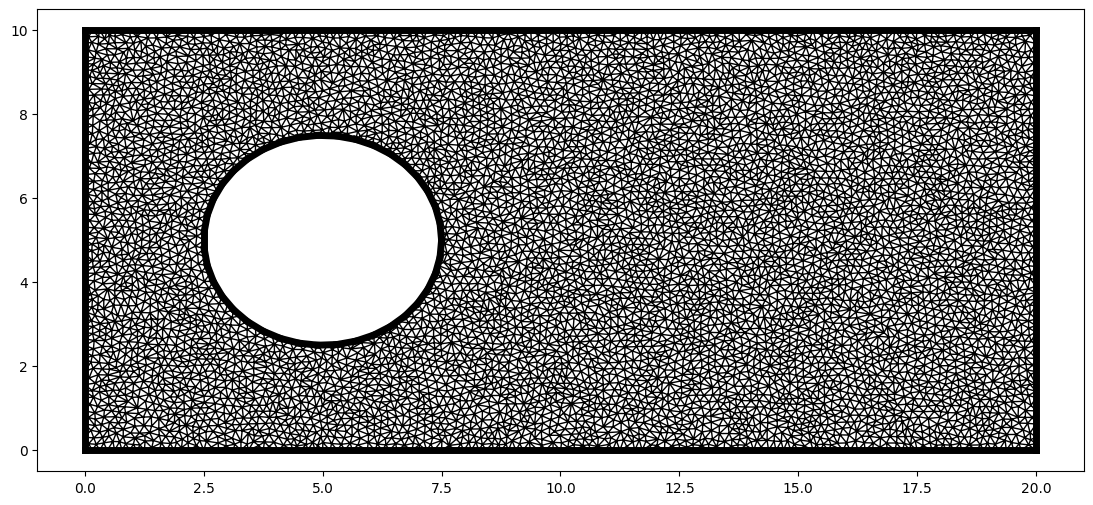

In [291]:
plot_mesh(mesh)
plot_boundary(boundary, mesh)
plt.show()

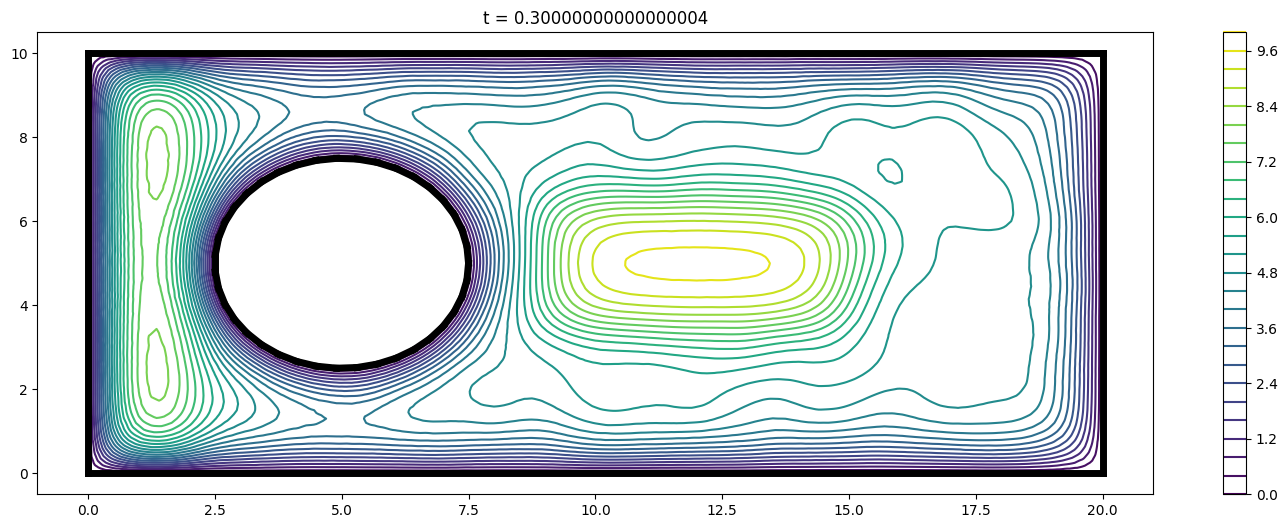

In [286]:
plot_solution(xs, ys, im, f"t = {delta_t*step}")
plot_boundary(boundary,mesh)
plt.show()

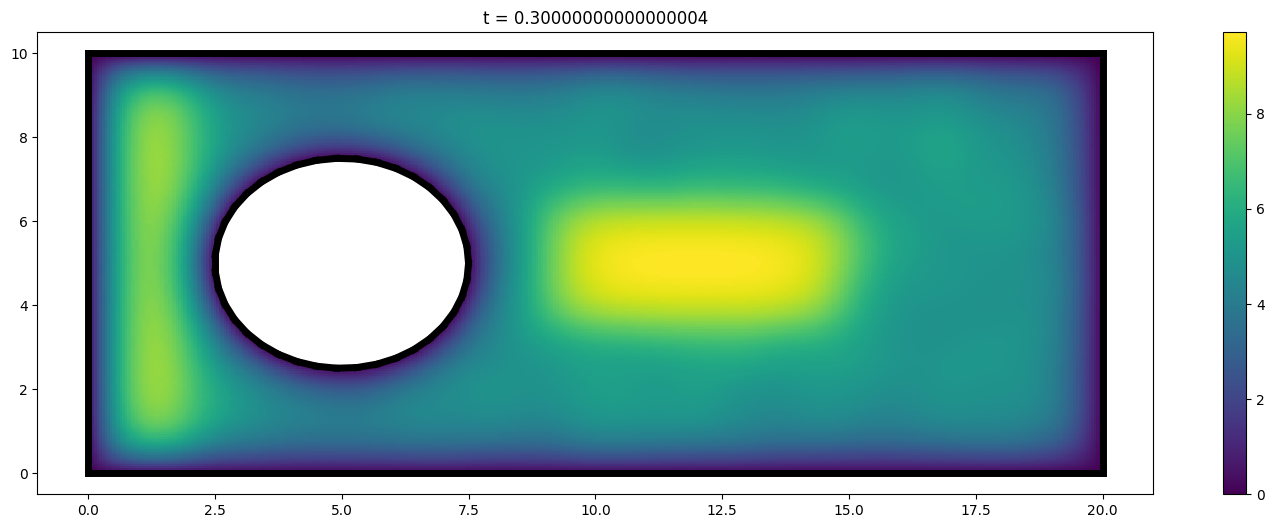

In [287]:
plot_solution(xs, ys, im, f"t = {delta_t*step}", kind="pcolormesh")
plot_boundary(boundary,mesh)
plt.show()